In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/140k-real-and-fake-faces


In [3]:
import pandas as pd
import numpy as np
import os
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
train_df = pd.read_csv(os.path.join(path, 'train.csv'))
test_df = pd.read_csv(os.path.join(path, 'test.csv'))
valid_df = pd.read_csv(os.path.join(path, 'valid.csv'))

print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)
print("Validation data shape:", valid_df.shape)

Training data shape: (100000, 6)
Testing data shape: (20000, 6)
Validation data shape: (20000, 6)


In [5]:
train_real_df = train_df[train_df['label'] == 1].copy()
train_fake_df = train_df[train_df['label'] == 0].copy()

test_real_df = test_df[test_df['label'] == 1].copy()
test_fake_df = test_df[test_df['label'] == 0].copy()

valid_real_df = valid_df[valid_df['label'] == 1].copy()
valid_fake_df = valid_df[valid_df['label'] == 0].copy()

print("Training data shapes:")
print("  Real:", train_real_df.shape)
print("  Fake:", train_fake_df.shape)
print("\nTesting data shapes:")
print("  Real:", test_real_df.shape)
print("  Fake:", test_fake_df.shape)
print("\nValidation data shapes:")
print("  Real:", valid_real_df.shape)
print("  Fake:", valid_fake_df.shape)

Training data shapes:
  Real: (50000, 6)
  Fake: (50000, 6)

Testing data shapes:
  Real: (10000, 6)
  Fake: (10000, 6)

Validation data shapes:
  Real: (10000, 6)
  Fake: (10000, 6)


In [6]:
# Select 10 real samples from the training data
num_samples = 4000
real_samples_df = train_real_df.sample(n=num_samples, random_state=42).copy()

print(f"Selected {num_samples} real samples for prediction:")
display(real_samples_df)

Selected 4000 real samples for prediction:


,Unnamed: 0,original_path,id,label,label_str,path
33553,33553,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,13537,1,real,train/real/13537.jpg
9427,9427,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33057,1,real,train/real/33057.jpg
199,199,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,48815,1,real,train/real/48815.jpg
12447,12447,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24376,1,real,train/real/24376.jpg
39489,39489,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,32406,1,real,train/real/32406.jpg
...,...,...,...,...,...,...
46735,46735,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,14059,1,real,train/real/14059.jpg
28681,28681,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31741,1,real,train/real/31741.jpg
46606,46606,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,38677,1,real,train/real/38677.jpg
7499,7499,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,68788,1,real,train/real/68788.jpg


In [7]:
from tensorflow import keras

# Define the paths to the trained models
model_paths = [
    '/content/real_vs_fake_custommodel.keras',
    '/content/real_vs_fake_custommode2.keras',
    '/content/real_vs_fake_custommode3.keras'
]

# Load the models
loaded_models = []
for model_path in model_paths:
    try:
        model = keras.models.load_model(model_path)
        loaded_models.append(model)
        print(f"Successfully loaded model from: {model_path}")
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")

print(f"\nLoaded {len(loaded_models)} models.")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 34 variables whereas the saved optimizer has 66 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Successfully loaded model from: /content/real_vs_fake_custommodel.keras
Successfully loaded model from: /content/real_vs_fake_custommode2.keras
Successfully loaded model from: /content/real_vs_fake_custommode3.keras

Loaded 3 models.


In [8]:
# Create a new DataFrame to store predictions
prediction_df = real_samples_df[['path']].copy()

# Add columns for each model's predictions
for i, model in enumerate(loaded_models):
    prediction_df[f'model_{i+1}_prediction'] = None

display(prediction_df.head())

,path,model_1_prediction,model_2_prediction,model_3_prediction
33553,train/real/13537.jpg,None,None,None
9427,train/real/33057.jpg,None,None,None
199,train/real/48815.jpg,None,None,None
12447,train/real/24376.jpg,None,None,None
39489,train/real/32406.jpg,None,None,None


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
img_size = (224, 224)
batch_size = 32
image_base_path = os.path.join(path, 'real_vs_fake', 'real-vs-fake')
test_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=real_samples_df, # Use the original dataframe that contains 'label_str'
    directory=image_base_path,
    x_col='path',
    y_col='label_str',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical', # Use 'categorical' for string labels
    classes=['fake', 'real'], # Explicitly define the classes
    shuffle=False # Set shuffle to False for consistent prediction order
)

Found 4000 validated image filenames belonging to 2 classes.


In [10]:
# Make predictions with each loaded model and fill the prediction_df
for i, model in enumerate(loaded_models):
    # Use the test_generator to get predictions for each image in the batch
    predictions = model.predict(test_generator, steps=len(test_generator))

    # Flatten the predictions if they are in nested arrays
    if isinstance(predictions[0], (list, np.ndarray)):
        predictions = [pred[0] for pred in predictions]

    # Add the predictions to the prediction_df
    prediction_df[f'model_{i+1}_prediction'] = predictions[:len(prediction_df)]

print("Prediction DataFrame with model predictions:")
display(prediction_df.head())

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 597ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 51s 403ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 52s 406ms/step
Prediction DataFrame with model predictions:


,path,model_1_prediction,model_2_prediction,model_3_prediction
33553,train/real/13537.jpg,0.512710,0.888174,0.719375
9427,train/real/33057.jpg,0.995009,0.875097,0.806919
199,train/real/48815.jpg,0.902763,0.971899,0.904829
12447,train/real/24376.jpg,0.981759,0.961847,0.841474
39489,train/real/32406.jpg,0.991615,0.813679,0.740385


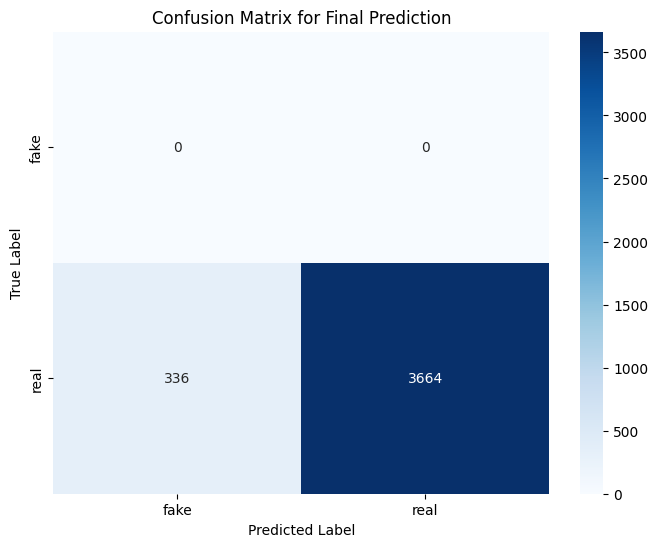

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Merge prediction_df with real_samples_df to get the true labels
# Assuming 'path' is a common column and can be used for merging
merged_df = pd.merge(prediction_df, real_samples_df[['path', 'label_str']], on='path', how='left')

# Get the true labels and the final predictions
y_true = merged_df['label_str']
y_pred = merged_df['final_prediction']

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['fake', 'real'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Final Prediction')
plt.show()

In [11]:
# Define a threshold for classifying as 'real' or 'fake'
threshold = 0.5

# Apply the threshold to each model's predictions
for i in range(1, len(loaded_models) + 1):
    prediction_df[f'model_{i}_label'] = prediction_df[f'model_{i}_prediction'].apply(
        lambda x: 'real' if x > threshold else 'fake'
    )

# Compute the voting result (majority vote)
prediction_df['final_prediction'] = prediction_df[[f'model_{i}_label' for i in range(1, len(loaded_models) + 1)]].mode(axis=1)[0]

print("Prediction DataFrame with model labels and final prediction:")
display(prediction_df.head())

Prediction DataFrame with model labels and final prediction:


,path,model_1_prediction,model_2_prediction,model_3_prediction,model_1_label,model_2_label,model_3_label,final_prediction
33553,train/real/13537.jpg,0.512710,0.888174,0.719375,real,real,real,real
9427,train/real/33057.jpg,0.995009,0.875097,0.806919,real,real,real,real
199,train/real/48815.jpg,0.902763,0.971899,0.904829,real,real,real,real
12447,train/real/24376.jpg,0.981759,0.961847,0.841474,real,real,real,real
39489,train/real/32406.jpg,0.991615,0.813679,0.740385,real,real,real,real


In [26]:
valid_sample_df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Face_Datasets/train_df3.csv")
valid_sample_df.head()

,Unnamed: 0,original_path,id,label,label_str,path
0,20000,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,05421,1,real,train/real/05421.jpg
1,20000,/kaggle/input/1-million-fake-faces/1m_faces_04...,5M6YD19C4E,0,fake,train/fake/5M6YD19C4E.jpg
2,20001,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,07955,1,real,train/real/07955.jpg
3,20001,/kaggle/input/1-million-fake-faces/1m_faces_12...,JEYGAG5TKT,0,fake,train/fake/JEYGAG5TKT.jpg
4,20002,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,04178,1,real,train/real/04178.jpg


In [31]:
valid_sample_df= valid_sample_df.sample(frac=0.4, random_state=42)
# Store the original labels separately for comparison
sampled_test2_labels = valid_sample_df[['label', 'label_str']].copy()

# Remove the 'label' and 'label_str' columns from the sampled dataframe for prediction
sampled_test2_df_for_prediction = valid_sample_df.drop(['label', 'label_str'], axis=1)

# Display the shape and head of the sampled dataframe for prediction and the labels dataframe
print("Shape of the sampled dataframe for prediction:", sampled_test2_df_for_prediction.shape)
display(sampled_test2_df_for_prediction.head())

print("\nShape of the sampled labels dataframe:", sampled_test2_labels.shape)
display(sampled_test2_labels.head())

Shape of the sampled dataframe for prediction: (8000, 4)


,Unnamed: 0,original_path,id,path
10650,25325,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,65475,train/real/65475.jpg
2041,21020,/kaggle/input/1-million-fake-faces/1m_faces_08...,GX1C1XPJ6W,train/fake/GX1C1XPJ6W.jpg
8668,24334,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,10465,train/real/10465.jpg
1114,20557,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,20378,train/real/20378.jpg
13902,26951,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11997,train/real/11997.jpg



Shape of the sampled labels dataframe: (8000, 2)


,label,label_str
10650,1,real
2041,0,fake
8668,1,real
1114,1,real
13902,1,real


In [35]:
# Create a new DataFrame to store predictions
prediction_df2 = sampled_test2_df_for_prediction[['path']].copy()

# Add columns for each model's predictions
for i, model in enumerate(loaded_models):
    prediction_df2[f'model_{i+1}_prediction'] = None

display(prediction_df2.head())

,path,model_1_prediction,model_2_prediction,model_3_prediction
10650,train/real/65475.jpg,None,None,None
2041,train/fake/GX1C1XPJ6W.jpg,None,None,None
8668,train/real/10465.jpg,None,None,None
1114,train/real/20378.jpg,None,None,None
13902,train/real/11997.jpg,None,None,None


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size (using the same as before)
img_size = (224, 224)
batch_size = 32
image_base_path = os.path.join(path, 'real_vs_fake', 'real-vs-fake')

# Create a new ImageDataGenerator for the sampled test data
test2_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test2_generator = test2_datagen.flow_from_dataframe(
    dataframe=sampled_test2_df_for_prediction,
    directory=image_base_path,
    x_col='path',
    y_col=None,  # No labels for this generator as we will predict
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None, # Set class_mode to None for prediction
    shuffle=False
)

print("Test2 generator created.")

Found 8000 validated image filenames.
Test2 generator created.


In [36]:
# Make predictions with each loaded model and fill the prediction_df2
for i, model in enumerate(loaded_models):
    # Use the test2_generator to get predictions for each image in the batch
    predictions = model.predict(test2_generator, steps=len(test2_generator))

    # Flatten the predictions if they are in nested arrays
    if isinstance(predictions[0], (list, np.ndarray)):
        predictions = [pred[0] for pred in predictions]

    # Add the predictions to the prediction_df2
    prediction_df2[f'model_{i+1}_prediction'] = predictions[:len(prediction_df2)]

print("Prediction DataFrame 2 with model predictions:")
display(prediction_df2.head())

250/250 ━━━━━━━━━━━━━━━━━━━━ 104s 417ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 103s 410ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 102s 404ms/step
Prediction DataFrame 2 with model predictions:


,path,model_1_prediction,model_2_prediction,model_3_prediction
10650,train/real/65475.jpg,0.946083,0.971823,0.918341
2041,train/fake/GX1C1XPJ6W.jpg,0.016666,0.909387,0.638822
8668,train/real/10465.jpg,0.914208,0.880635,0.639343
1114,train/real/20378.jpg,0.902739,0.865461,0.658044
13902,train/real/11997.jpg,0.913851,0.765019,0.521783


In [37]:
# Define a threshold for classifying as 'real' or 'fake'
threshold = 0.5

# Apply the threshold to each model's predictions
for i in range(1, len(loaded_models) + 1):
    prediction_df2[f'model_{i}_label'] = prediction_df2[f'model_{i}_prediction'].apply(
        lambda x: 'real' if x > threshold else 'fake'
    )

# Compute the voting result (majority vote)
prediction_df2['final_prediction'] = prediction_df2[[f'model_{i}_label' for i in range(1, len(loaded_models) + 1)]].mode(axis=1)[0]

print("Prediction DataFrame with model labels and final prediction:")
display(prediction_df2.head())

Prediction DataFrame with model labels and final prediction:


,path,model_1_prediction,model_2_prediction,model_3_prediction,model_1_label,model_2_label,model_3_label,final_prediction
10650,train/real/65475.jpg,0.946083,0.971823,0.918341,real,real,real,real
2041,train/fake/GX1C1XPJ6W.jpg,0.016666,0.909387,0.638822,fake,real,real,real
8668,train/real/10465.jpg,0.914208,0.880635,0.639343,real,real,real,real
1114,train/real/20378.jpg,0.902739,0.865461,0.658044,real,real,real,real
13902,train/real/11997.jpg,0.913851,0.765019,0.521783,real,real,real,real


Accuracy: 0.8848
Precision: 0.8666
Recall: 0.9117
F1 Score: 0.8886


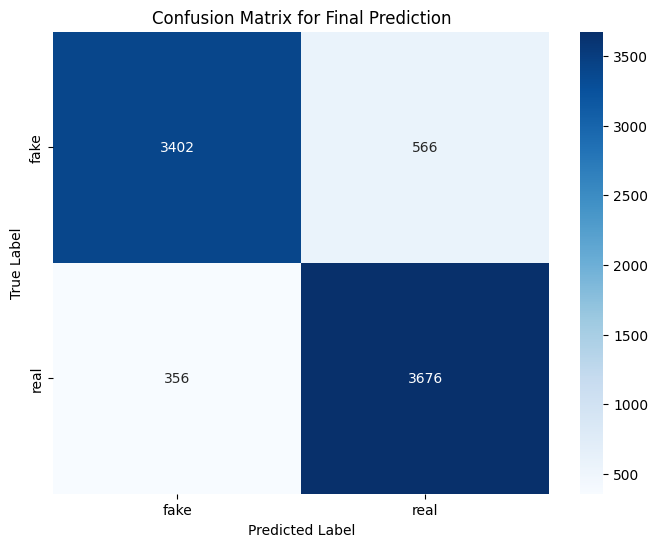

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Merge prediction_df with real_samples_df to get the true labels
# Assuming 'path' is a common column and can be used for merging
merged_df = pd.merge(prediction_df2, valid_sample_df[['path', 'label_str']], on='path', how='left')

# Get the true labels and the final predictions
y_true = merged_df['label_str']
y_pred = merged_df['final_prediction']

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label='real') # Assuming 'real' is the positive class
recall = recall_score(y_true, y_pred, pos_label='real')     # Assuming 'real' is the positive class
f1 = f1_score(y_true, y_pred, pos_label='real')         # Assuming 'real' is the positive class

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['fake', 'real'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Final Prediction')
plt.show()

Selected 4000 fake samples for prediction:


,Unnamed: 0,original_path,id,label,label_str,path
83553,33553,/kaggle/input/1-million-fake-faces/1m_faces_08...,OL08SKGKKF,0,fake,train/fake/OL08SKGKKF.jpg
59427,9427,/kaggle/input/1-million-fake-faces/1m_faces_00...,YAFZAZE05O,0,fake,train/fake/YAFZAZE05O.jpg
50199,199,/kaggle/input/1-million-fake-faces/1m_faces_12...,GICP3UTAEF,0,fake,train/fake/GICP3UTAEF.jpg
62447,12447,/kaggle/input/1-million-fake-faces/1m_faces_04...,F07AKINMZI,0,fake,train/fake/F07AKINMZI.jpg
89489,39489,/kaggle/input/1-million-fake-faces/1m_faces_00...,5OECSB88O4,0,fake,train/fake/5OECSB88O4.jpg


,path,model_1_prediction,model_2_prediction,model_3_prediction
83553,train/fake/OL08SKGKKF.jpg,None,None,None
59427,train/fake/YAFZAZE05O.jpg,None,None,None
50199,train/fake/GICP3UTAEF.jpg,None,None,None
62447,train/fake/F07AKINMZI.jpg,None,None,None
89489,train/fake/5OECSB88O4.jpg,None,None,None


Found 4000 validated image filenames.

Fake generator created.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 31s 248ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step

Prediction DataFrame for fake samples with model predictions:


,path,model_1_prediction,model_2_prediction,model_3_prediction
83553,train/fake/OL08SKGKKF.jpg,0.107023,0.098645,0.308109
59427,train/fake/YAFZAZE05O.jpg,0.003505,0.160806,0.464614
50199,train/fake/GICP3UTAEF.jpg,0.064474,0.220813,0.660281
62447,train/fake/F07AKINMZI.jpg,0.001893,0.138135,0.538813
89489,train/fake/5OECSB88O4.jpg,0.005354,0.030953,0.115031



Prediction DataFrame for fake samples with model labels and final prediction:


,path,model_1_prediction,model_2_prediction,model_3_prediction,model_1_label,model_2_label,model_3_label,final_prediction
83553,train/fake/OL08SKGKKF.jpg,0.107023,0.098645,0.308109,fake,fake,fake,fake
59427,train/fake/YAFZAZE05O.jpg,0.003505,0.160806,0.464614,fake,fake,fake,fake
50199,train/fake/GICP3UTAEF.jpg,0.064474,0.220813,0.660281,fake,fake,real,fake
62447,train/fake/F07AKINMZI.jpg,0.001893,0.138135,0.538813,fake,fake,real,fake
89489,train/fake/5OECSB88O4.jpg,0.005354,0.030953,0.115031,fake,fake,fake,fake



Evaluation Metrics for Fake Samples:
Accuracy: 0.8360
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


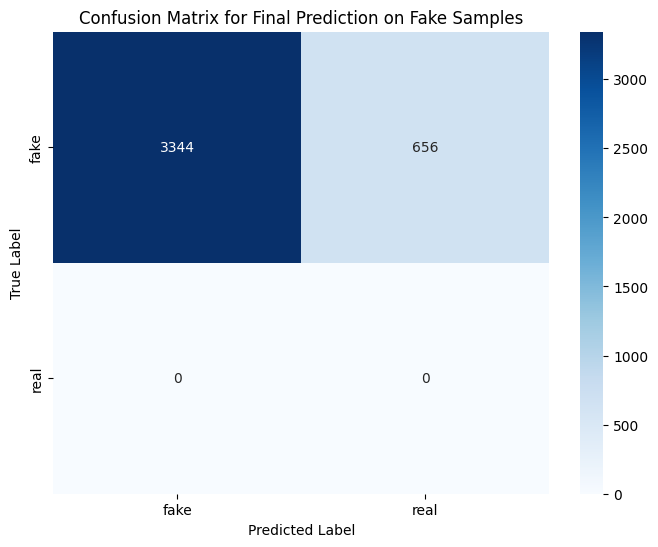

In [41]:
# Select a sample of only fake data from the training set
num_fake_samples = 4000  # You can adjust the number of fake samples as needed
fake_samples_df = train_fake_df.sample(n=num_fake_samples, random_state=42).copy()

print(f"Selected {num_fake_samples} fake samples for prediction:")
display(fake_samples_df.head())

# Create a new DataFrame to store predictions for fake samples
prediction_df_fake = fake_samples_df[['path']].copy()

# Add columns for each model's predictions
for i, model in enumerate(loaded_models):
    prediction_df_fake[f'model_{i+1}_prediction'] = None

display(prediction_df_fake.head())

# Create an ImageDataGenerator for the fake samples
fake_datagen = ImageDataGenerator(rescale=1./255) # No augmentation needed for prediction

fake_generator = fake_datagen.flow_from_dataframe(
    dataframe=fake_samples_df,
    directory=image_base_path,
    x_col='path',
    y_col=None,  # No labels needed for prediction
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None, # Set class_mode to None for prediction
    shuffle=False
)

print("\nFake generator created.")

# Make predictions with each loaded model and fill the prediction_df_fake
for i, model in enumerate(loaded_models):
    predictions = model.predict(fake_generator, steps=len(fake_generator))

    # Flatten the predictions if they are in nested arrays
    if isinstance(predictions[0], (list, np.ndarray)):
        predictions = [pred[0] for pred in predictions]

    # Add the predictions to the prediction_df_fake
    prediction_df_fake[f'model_{i+1}_prediction'] = predictions[:len(prediction_df_fake)]

print("\nPrediction DataFrame for fake samples with model predictions:")
display(prediction_df_fake.head())

# Define a threshold for classifying as 'real' or 'fake'
threshold = 0.5

# Apply the threshold to each model's predictions for fake samples
for i in range(1, len(loaded_models) + 1):
    prediction_df_fake[f'model_{i}_label'] = prediction_df_fake[f'model_{i}_prediction'].apply(
        lambda x: 'real' if x > threshold else 'fake'
    )

# Compute the voting result (majority vote) for fake samples
prediction_df_fake['final_prediction'] = prediction_df_fake[[f'model_{i}_label' for i in range(1, len(loaded_models) + 1)]].mode(axis=1)[0]

print("\nPrediction DataFrame for fake samples with model labels and final prediction:")
display(prediction_df_fake.head())

# Since all samples are fake, the true labels are 'fake' for all
y_true_fake = ['fake'] * len(prediction_df_fake)
y_pred_fake = prediction_df_fake['final_prediction']

# Compute evaluation metrics for fake samples
accuracy_fake = accuracy_score(y_true_fake, y_pred_fake)
precision_fake = precision_score(y_true_fake, y_pred_fake, pos_label='real') # Assuming 'real' is the positive class
recall_fake = recall_score(y_true_fake, y_pred_fake, pos_label='real')     # Assuming 'real' is the positive class
f1_fake = f1_score(y_true_fake, y_pred_fake, pos_label='real')         # Assuming 'real' is the positive class


# Print the metrics for fake samples
print(f"\nEvaluation Metrics for Fake Samples:")
print(f"Accuracy: {accuracy_fake:.4f}")
print(f"Precision: {precision_fake:.4f}")
print(f"Recall: {recall_fake:.4f}")
print(f"F1 Score: {f1_fake:.4f}")


# Compute the confusion matrix for fake samples
cm_fake = confusion_matrix(y_true_fake, y_pred_fake, labels=['fake', 'real'])

# Plot the confusion matrix for fake samples
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fake, annot=True, fmt='d', cmap='Blues', xticklabels=['fake', 'real'], yticklabels=['fake', 'real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Final Prediction on Fake Samples')
plt.show()